<a href="https://colab.research.google.com/github/cerr/CERR/blob/octave_dev/Jupyter_Notebooks/demo_convolutional_texture_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
In this notebook we demonstrate how to apply Law's filter to a sample image using CERR.

* [CERR](https://github.com/cerr/CERR) provides open-source implementations of several convolutional texture filters, viz., Mean, Laplacian of Gaussian (LoG), Sobel, Laws, Gabor, and Wavelets.

* Filter definitions are compatible with IBSI [guidelines](https://www.overleaf.com/project/5da9e0b82f399f0001ad3970).

### Requirements

* GNU Octave with `statistics` & `image` packages
* CERR
* Python packages for visualization

Note: Installing these tools may incur a one-time extra runtime overhead.

### I/O

In this example, we use sample images in CERR's native `planC` format (imported from DICOM) to compute Law's texture maps, output to Octave and numpy matrices.
 
### Results
This notebook comes with a static visualization of a sample filter output.  A second interactive display section is additionally made available on running the notebook.

---

# Install dependencies 
Uncomment (`Ctrl+/`) the following to install (1) Octave with required packages (2) Oct2py and (3) CERR.

### Download latest Octave compile

In [1]:
# %%capture
# ! apt-get update
# ! apt-get install libgraphicsmagick++1-dev libsuitesparse-dev libqrupdate1 \
# libfftw3-3 gnuplot zsh openjdk-8-jdk


In [2]:
%%capture
# # Download compiled octave package (latest)
# def get_Octave(root_path):
#  os.chdir(root_path)
#  with urllib.request.urlopen("https://api.github.com/repos/cerr/octave-colab/releases/latest") as url:
#      data = json.loads(url.read().decode())
#  fname = data['assets'][0]['name']
#  requrl = data['assets'][0]['browser_download_url']
#  urllib.request.urlretrieve(requrl, fname)
#  # unzip, identify octave folder name
#  !tar xf {fname}
#  top_folder = !tar tf {fname} | head -1
#  octave_folder = top_folder[0][:-1]
#  octave_path = os.path.join(root_path,octave_folder)
#  return octave_path

In [3]:
# Define Octave path
# import os, urllib.request, json
# octave_path = get_Octave('/content')
os.environ['OCTAVE_EXECUTABLE'] = octave_path + '/bin/octave-cli' #Replace with OCTAVE_EXECUTABLE path
os.environ['PATH'] = octave_path + '/bin:' + os.environ['PATH']   #Replace with Octave path

### Install Octave-Python bridge

In [4]:
#%%capture
# ! pip3 install octave_kernel
# ! pip3 install oct2py==5.3.0

### Download CERR

In [5]:
%%capture
# !git clone --single-branch --branch octave_dev https://www.github.com/cerr/CERR.git
# import os   >< 
# currDir = os.getcwd()
# os.chdir("/content/CERR")
# !git checkout c2b65179da40622bc7b095f679edd17f5ebc681e
# os.chdir(currDir)

-----

# Generate & visualize texture maps using CERR

### Load required Octave packages 

In [6]:
%load_ext oct2py.ipython
from oct2py import octave

In [7]:
%%capture
%%octave
pkg load statistics
pkg load image

### Compute texture maps

In [8]:
%%octave

#Add CERR to path
cerrPath = '/content/CERR'
currDir = pwd;
cd(cerrPath)
addToPath2(cerrPath)
cd(currDir)

#Load test image 
parts = strsplit(getCERRPath, filesep);
CERR_dir = strjoin(parts(1:end-2), filesep);
sampleData = fullfile(CERR_dir,['Unit_Testing/data_for_cerr_tests/',...
                      'IBSI2_synthetic_phantoms/checkerboard.mat']);
planC = loadPlanC(sampleData, tempdir);
planC = updatePlanFields(planC);
planC = quality_assure_planC(sampleData, planC);

In [9]:
%%capture
%%octave

#Path to sample configurations for benchmarking Laws' conv. filter
configFile =  fullfile(cerrPath,['Unit_Testing/settings_for_comparisons/',...
                         'IBSIPhase2-1ID2c.json'])

#Compute texture map
structNum = 1; #Whole scan
scanNum = 1;
init_ML_DICOM;
planC = generateTextureMapFromPlanC(planC,scanNum,structNum,configFile);

In [10]:
%%capture
%%octave
## For display:

#Get original scan array
indexS = planC{end};
scanNum = 1;
ctOffset = planC{indexS.scan}(scanNum).scanInfo(1).CTOffset;
origScanArray = single(getScanArray(scanNum,planC)) - ctOffset;

#Get texture map
scanNum = 2;
ctOffset = planC{indexS.scan}(scanNum).scanInfo(1).CTOffset;
textureMap = single(getScanArray(scanNum,planC)) - ctOffset;

### Visualization (using Python/Matplotlib)

In [11]:
%octave_pull origScanArray textureMap

In [12]:
import matplotlib.pyplot as plt
import numpy as np

dx, dy = 1, 1

x = np.arange(0, 256, dx)
y = np.arange(0, 256, dy)
extent = np.min(x), np.max(x), np.min(y), np.max(y)

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image


### Example: display center slice

Slice 32


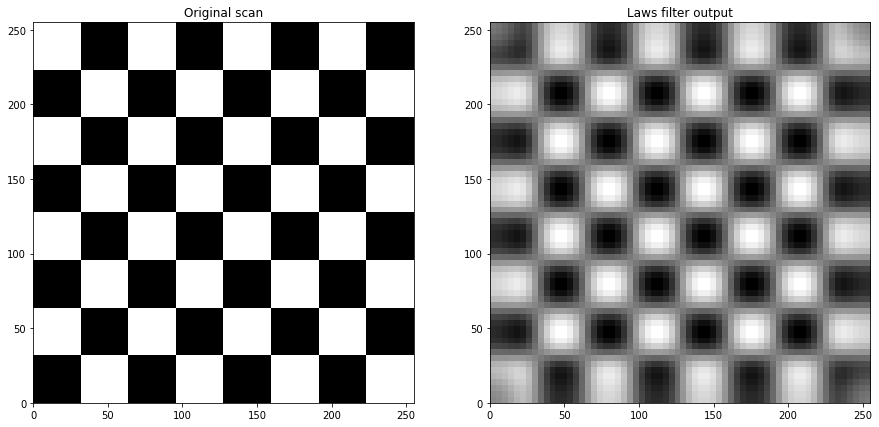

In [13]:
# Plot center slice
scanSize = np.shape(origScanArray)
centerSlc = np.round(scanSize[2]/2).astype(int)
print('Slice '+ str(centerSlc))      

window_center = 40
window_width = 400
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,15))

windowed_img = window_image(origScanArray[:,:,centerSlc],
                                window_center,window_width)
ax1.imshow(windowed_img, cmap=plt.cm.gray, alpha=1,
                    interpolation='nearest', extent=extent)
ax1.title.set_text('Original scan')

windowed_img = window_image(textureMap[:,:,centerSlc],
                                window_center,window_width)
ax2.imshow(windowed_img,cmap=plt.cm.gray, alpha=1,
                    interpolation='nearest', extent=extent) 
ax2.title.set_text('Law''s filter output')


### Interactive display

In [14]:
# Interactive display

from IPython.display import clear_output
import ipywidgets as widgets

def show_axial_slice(slcNum):
    clear_output(wait=True)
    print('Slice '+str(slcNum))
    if 'fig' in locals():
        fig.remove()
        
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,15))
    window_center = 40
    window_width = 400
    windowed_img = window_image(origScanArray[:,:,slcNum-1],
                                window_center,window_width)
    ax1.imshow(windowed_img, cmap=plt.cm.gray, alpha=1,
                    interpolation='nearest', extent=extent)
    ax1.title.set_text('Original scan')
    
    
    windowed_img = window_image(textureMap[:,:,slcNum-1],
                                window_center,window_width)
    ax2.imshow(textureMap[:,:,slcNum-1],cmap=plt.cm.gray, alpha=1,
                    interpolation='nearest', extent=extent) 
    ax2.title.set_text('Law''s filter output')
    plt.show()

slice_slider = widgets.IntSlider(value=10,min=1,max=22,step=1)
outputSlc = widgets.Output()

display(slice_slider, outputSlc)

def update_slice(change):
    with outputSlc:
        show_axial_slice(change['new'])

slice_slider.observe(update_slice, names='value')

IntSlider(value=10, max=22, min=1)

Output()